# MRI Super Resolution with a Deep 3D Resnet Variant

# James Golden

## jgolden1@stanford.edu

## Problem setup 

A high-resolution MRI dataset from http://old.mridata.org/fullysampled/knees is blurred to simulate fast, low-resolution acquisition. A deep network was trained to carry out super resolution on the blurred volumetric data. There are 19 patients total, and 16 were used for training and validation while the remaining three were used for testing.


## General approach

I implemented a resnet-like 3D super resolution network in Pytorch. I generated a training set of 32x32x32 volume blocks from the MRI data for each of the 19 patients, and trained/validated on the first 15 patients and tested on the last 4 patients. The network is fully convolutional, so it can be trained on small volumes and tested on any size volume.

The network I built generally followed the approach of "Enhanced Deep Residual Networks for Single Image Super-Resolution" (https://arxiv.org/abs/1707.02921 by Bee Lim, Sanghyun Son, Heewon Kim, Seungjun Nah, Kyoung Mu Lee), but adapted for 3D volume data. The residual block was composed of 64 3x3x3 conv kernels followed by a ReLu followed by another block of 64 3x3x3 conv kernels, and I used a total of 9 res blocks. (I wanted to use more, but this filled up the 12 GB of GPU memory I had available.) 

I prototyped on smaller 8x8x8 and 16x16x16 volumes in order to experiment with different network architectures. I was unsure about the conv-ReLu-conv structure of the res blocks, so I also experimented with just conv-ReLu, but I found the extra conv block was actually improving the training.

I settled on the mean squared error as the loss function, with the input as the blurred volume data block and the output as the original volume data. I tried L1 loss, but had trouble getting the network to converge, and the results just didn't look that good. I was thinking it could be fun to try some sort of feature loss by putting 2D slices from the predicted volumes through a pre-trained image classification network, but I didn't get to, and I don't think my GPU could have handled that anyway.

I also used the Fast AI toolbox as well (https://github.com/fastai by Jeremy Howard, Rachel Thomas, et al., a bit like Keras for Pytorch), which has a nice data loader tool that comes with easy data augmentation. However, the data loader was built for 2D images, so I had to spend a day hacking functions in the data loader to get it to work with 3D volume data. I succeeded, but didn't get the augmentation to work with volumes (it is still on my to-do list). Some of my code comes from Fast AI for using the data loader. Fast AI also has a super resolution image demo with a resnet variant that I used as a scaffold for my network.

## Imports

In [1]:
from os.path import dirname, join
from pprint import pprint

import pydicom
from pydicom.data import get_testdata_files
from pydicom.filereader import read_dicomdir

import glob
import h5py
# fastai
import sys
sys.path.append('/home/james/Documents/pyt/fastai')
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.conv_learner import *
from pathlib import Path

## Load training data

In [3]:

PATH = Path('/home/james/Documents/mri/batches')
PATH_TRN = PATH/'train'

fnames_full,label_arr_full,all_labels = folder_source(PATH, 'train')

# Get only the list of blurred 32x32x32 volume hdf files, originals have 'y' in file name
fnames_full = ['/'.join(Path(fn).parts[-2:]) for fn in fnames_full if 'y' not in fn]

In [5]:
# Set aside a portion for validation
np.random.seed(42)
keep_pct = 1.
keeps = np.random.rand(len(fnames_full)) < 10
fnames = np.array(fnames_full, copy=False)[keeps]

In [6]:
# Get only the original, non-blurred volumes
fnamesy = [fi[:-3] + '_y.h5' for fi in fnames]

### Compare file names for x and y to make sure the correct blurred and original volumes are paired together

In [7]:
list(zip(fnames[:5],fnamesy[:5]))

[('p0/vol_p0_63.h5', 'p0/vol_p0_63_y.h5'),
 ('p0/vol_p0_1004.h5', 'p0/vol_p0_1004_y.h5'),
 ('p0/vol_p0_467.h5', 'p0/vol_p0_467_y.h5'),
 ('p0/vol_p0_1876.h5', 'p0/vol_p0_1876_y.h5'),
 ('p0/vol_p0_340.h5', 'p0/vol_p0_340_y.h5')]

In [9]:
# Set batch size and size of input and output training volume blocks
bs = 1
sz_lr = 32
sz_hr = sz_lr

### Build a custom data loader for fast ai that can handle volume data
(Note: there are many additional changes I made to the data loader code in my fork of the fast ai repo)

In [10]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, fnamesy, transform, path):
        self.fnamesy=fnamesy
        assert(len(fnames)==len(fnamesy))
        super().__init__(fnames, transform, path)
    def get_y(self, i): 
        return open_volume(os.path.join(self.path, self.fnamesy[i]))
    def get_c(self): return 0

### Set data augmentation
I am still working on using the data augmentation for volume data. The PassThru transform does not augment the data.

In [12]:
# aug_tfms = [RandomDihedral(tfm_y=TfmType.PIXEL)]
aug_tfms = [PassThru(tfm_y=TfmType.PIXEL)]

### Build the training and validation sets for both blurred and original volume block data
I created a small validation set on purpose because I knew I would not have time to ensemble networks From different k-fold cross-validated training sessions. I would have done that with more time. The small validation set allowed me to maximize the accuracy of the network given the training data.

I also realize the training set is quite small. I removed volume blocks with variance below a certain threshold in order to avoid training on volumes with no interesting anatomical data. Ideally augmentation will improve this.

In [13]:
# Split training and validation sets
val_idxs = get_cv_idxs(len(fnames), val_pct=min(0.01/keep_pct, 0.1))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), np.array(fnamesy))
len(val_x),len(trn_x)

(168, 16635)

## Apply the custom data loader to prepare the training data

In [14]:
# Apply data augmentations - unfortunately we did not use any, but will in the future.
tfms = tfms_from_model(arch, sz_lr, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms, sz_y=sz_hr)

# Create the custom data loader for the network with the training data. See fast ai documentation for more details. 
# I spent a whole day altering the data loader to work with volume data.
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH_TRN)
# datasets = ImageData.get_ds(FilesXYDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH_TRN)

# Initialize the pytorch model with the training data
md = ImageData(PATH, datasets, bs, num_workers=1, classes=None)

In [17]:
# Check the data loader
md.trn_dl

In [18]:
# Check sizes of training set: (batch, channel, x, y, z)
x,y = next(iter(md.trn_dl))
x.size(),y.size()

(torch.Size([64, 1, 32, 32, 32]), torch.Size([64, 1, 32, 32, 32]))

## Check images of the volume data to make sure it looks good
Check that the blurred volumes generally match the original volumes

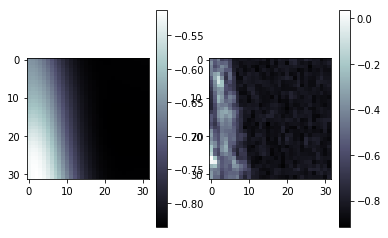

In [23]:
plt.subplot(1,2,1)
bind = 31
plt.imshow(torch.squeeze(x[bind,0,7,:,:]),cmap=plt.cm.bone)

plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(torch.squeeze(y[bind,0,7,:,:]),cmap=plt.cm.bone)

plt.colorbar()

## Check 3D slices to make sure blurred and original data match

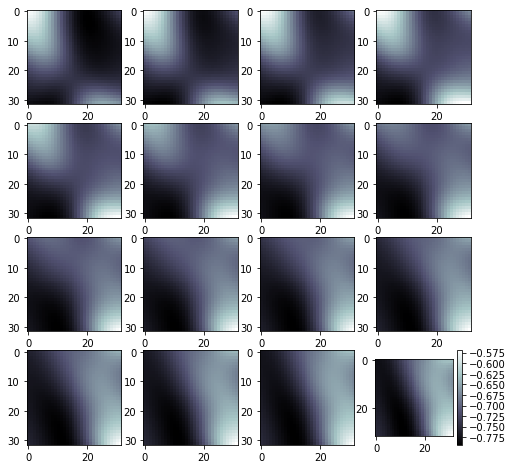

In [26]:
# np.shape(preds)
bind = 39
plt.figure(figsize=[8,8])
for pi in range(16):
    plt.subplot(4,4,pi+1)
    plt.imshow(torch.squeeze(x[bind,0,:,:,pi]),cmap=plt.cm.bone)
    
plt.colorbar()

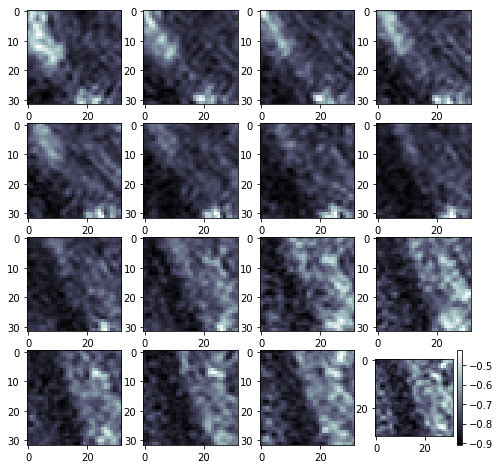

In [27]:
# np.shape(preds)
# bind = 39
plt.figure(figsize=[8,8])
for pi in range(16):
    plt.subplot(4,4,pi+1)
    plt.imshow(torch.squeeze(y[bind,0,:,:,pi]),cmap=plt.cm.bone)
    
plt.colorbar()

### Check residual from this data volume to make sure the network has something to learn

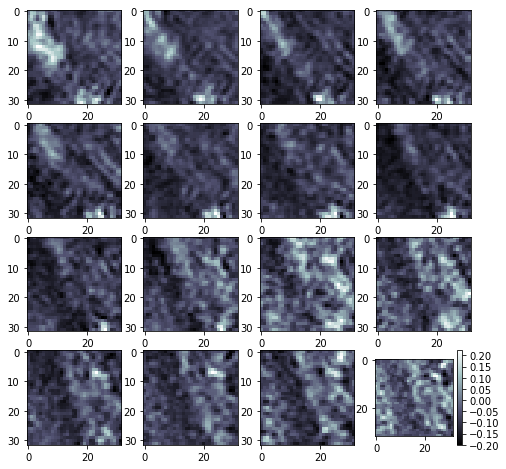

In [28]:
# np.shape(preds)
# bind = 39
plt.figure(figsize=[8,8])
for pi in range(16):
    plt.subplot(4,4,pi+1)
    plt.imshow(torch.squeeze(y[bind,0,:,:,pi]-x[bind,0,:,:,pi]),cmap=plt.cm.bone)
plt.colorbar()

# Build the resnet for super resolution

#### A resnet-like 3D super resolution network in Pytorch.

The network I built generally followed the approach of "Enhanced Deep Residual Networks for Single Image Super-Resolution" (https://arxiv.org/abs/1707.02921), but adapted for 3D volume data. The residual block was composed of 64 3x3x3 conv kernels followed by a ReLu followed by another block of 64 3x3x3 conv kernels, and I used a total of 9 res blocks. (I wanted to use more, but this filled up the 12 GB of GPU memory I had available.) 

### The network was assembled in a modular fashion:

First, a 3D convolution block with a 3x3x3 kernal was designed:

In [34]:
def conv(ni, nf, kernel_size=3, actn=False):
    layers = [nn.Conv3d(ni, nf, kernel_size, padding=kernel_size//2)]
    if actn: layers.append(nn.ReLU(True))
    return nn.Sequential(*layers)

The a residual block framework was assembled. This takes an input, applies the convolutional processing in its layers to compute the residual, and adds a scaled version of the residual to the original input:

In [35]:
class ResSequential(nn.Module):
    def __init__(self, layers, res_scale=1.0):
        super().__init__()
        self.res_scale = res_scale
        self.m = nn.Sequential(*layers)

    def forward(self, x): return x + self.m(x) * self.res_scale

The actual residual block was created, incorporating the ResSequential framework and the 3x3x3 conv block with 64 channels/kernels:

In [36]:
def res_block(nf):
    return ResSequential(
        [conv(nf, nf, actn=True), conv(nf, nf)],
        1.0) # this is best one


The network was then assembled by appending res blocks with convolutional processing 9 times, with a convolutional operation at the beginning to scale up to 64 channels, and one at the end to scale down to 1 channel.

In [38]:
class SrResnet(nn.Module):
    def __init__(self, nf):
        super().__init__()
        features = [conv(1, nf)]
        for i in range(9): features.append(res_block(nf))
        features += [conv(nf,nf), 
#                      nn.BatchNorm2d(nf),
                     conv(nf, 1)]
        self.features = nn.Sequential(*features)
        
    def forward(self, x): return self.features(x)

## Training

I used the training tools from fastai to train the 3D resnet. There is a tool for finding maximum stable learning rate by examining the loss on small batches for a large range of learning reates. Once I chose a learning rate, I examined the training and validation loss over time and observed that they decreased.

I chose MSE as the loss function. This is the standard, but in the EDSR paper they used L1 loss mainly. This didn't really work for me, as it didn't converge always, and when it did, the super res volumes just didn't look good.

In [40]:
m = to_gpu(SrResnet(64))
# m = nn.DataParallel(m, [0,2])
learn = Learner(md, SingleModel(m), opt_fn=optim.Adam)
learn.crit = F.mse_loss
# learn.crit = F.l1_loss

The learning rate choice tool. I chose 2e-3, almost the highest rate I tested, because I've found that using rates at the bottom of the curve are unstable, but close to the bottom work well.

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 94%|█████████▍| 292/309 [04:26<00:15,  1.10it/s, loss=0.162] 

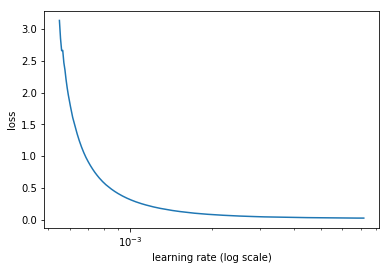

In [48]:
learn.lr_find(start_lr=5e-4, end_lr=9e-3)
learn.sched.plot()

In [41]:
lr=1.4e-3

## The training process
I trained the network for a total of about 6 hours. I trained for as much time as I had until the improvement seemed within some error value - admittedly this was just a guess, and if I had more time I would certainly try to improve the final prediction error.

I realize this is a bit messy, but it was very late when this started to work. Each cell is a training iteration that took 18-20 minutes. I saved each iteration with a terrible file name because I went to sleep and didn't want to lose the network if it diverged at some point.

In [43]:
# learn.fit(lr*.85, 1, cycle_len=1, use_clr_beta=(40,10))

# learn.save('/home/james/Documents/mri/saved_models/32x32_mse_0198_working2')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.016814   0.015835  



Loss over training batches:

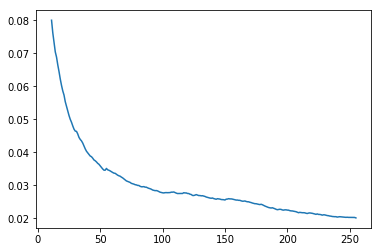

In [43]:
learn.sched.plot_loss()

In [44]:

learn.fit(lr*.7, 1, cycle_len=1, use_clr_beta=(40,10))

learn.save('/home/james/Documents/mri/saved_models/32x32_mse_0198_working3')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.018716   0.017114  



In [45]:

learn.fit(lr*.6, 1, cycle_len=1, use_clr_beta=(40,10))

learn.save('/home/james/Documents/mri/saved_models/32x32_mse_0198_working4')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.015839   0.015032  



In [46]:

learn.fit(lr*.5, 1, cycle_len=1, use_clr_beta=(40,10))

learn.save('/home/james/Documents/mri/saved_models/32x32_mse_0198_working5')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.014886   0.014353  



In [47]:

learn.fit(lr*.4, 1, cycle_len=1, use_clr_beta=(40,10))

learn.save('/home/james/Documents/mri/saved_models/32x32_mse_0198_working6')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.01422    0.013884  



In [48]:

learn.fit(lr*.3, 1, cycle_len=1, use_clr_beta=(40,10))

learn.save('/home/james/Documents/mri/saved_models/32x32_mse_0198_working7')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.014263   0.013559  



In [49]:

learn.fit(lr*.2, 1, cycle_len=1, use_clr_beta=(40,10))

learn.save('/home/james/Documents/mri/saved_models/32x32_mse_0198_working8')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.013383   0.013322  



In [50]:

learn.fit(lr*.1, 1, cycle_len=1, use_clr_beta=(40,10))

learn.save('/home/james/Documents/mri/saved_models/32x32_mse_0198_working9')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.013284   0.013175  



In [51]:

learn.fit(lr*.09, 1, cycle_len=1, use_clr_beta=(40,10))

learn.save('/home/james/Documents/mri/saved_models/32x32_mse_0198_working10')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.013593   0.013098  



In [52]:

learn.fit(lr*.08, 1, cycle_len=1, use_clr_beta=(40,10))

learn.save('/home/james/Documents/mri/saved_models/32x32_mse_0198_working11')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.012872   0.012981  



In [53]:

learn.fit(lr*.05, 1, cycle_len=1, use_clr_beta=(40,10))

learn.save('/home/james/Documents/mri/saved_models/32x32_mse_0198_working12')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.013612   0.012895  



In [54]:

learn.fit(lr*.05, 1, cycle_len=1, use_clr_beta=(40,10))

learn.save('/home/james/Documents/mri/saved_models/32x32_mse_0198_working13')
learn.fit(lr*.05, 1, cycle_len=1, use_clr_beta=(40,10))

learn.save('/home/james/Documents/mri/saved_models/32x32_mse_0198_working14')
learn.fit(lr*.05, 1, cycle_len=1, use_clr_beta=(40,10))

learn.save('/home/james/Documents/mri/saved_models/32x32_mse_0198_working15')
learn.fit(lr*.05, 1, cycle_len=1, use_clr_beta=(40,10))

learn.save('/home/james/Documents/mri/saved_models/32x32_mse_0198_working16')
learn.fit(lr*.05, 1, cycle_len=1, use_clr_beta=(40,10))

learn.save('/home/james/Documents/mri/saved_models/32x32_mse_0198_working17')
learn.fit(lr*.05, 1, cycle_len=1, use_clr_beta=(40,10))

learn.save('/home/james/Documents/mri/saved_models/32x32_mse_0198_working18')
learn.fit(lr*.05, 1, cycle_len=1, use_clr_beta=(40,10))

learn.save('/home/james/Documents/mri/saved_models/32x32_mse_0198_working19')
learn.fit(lr*.05, 1, cycle_len=1, use_clr_beta=(40,10))

learn.save('/home/james/Documents/mri/saved_models/32x32_mse_0198_working20')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.012787   0.012827  



HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.013223   0.012779  



HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.013026   0.012734  



HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.013111   0.012677  



HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.01279    0.012631  



HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.012282   0.012575  



HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.012495   0.012545  



HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.012631   0.012501  



Text(0,0.5,'Training Loss')

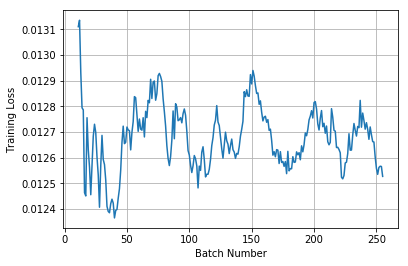

In [111]:
learn.sched.plot_loss()
plt.grid()
plt.xlabel('Batch Number')
plt.ylabel('Training Loss')

# The validation process after convergence
### With the network trained, I reloaded the best version and validated its performance, first on small volumes and further below on the big volumes from the test set.

In [70]:
# Load the network with the best training/validation score
learn.load('/home/james/Documents/mri/saved_models/32x32_mse_0198_working18')

In [71]:
# Iterate to the next validation step to examine outputs
x,y = next(iter(md.val_dl))
preds = learn.model(VV(x))

Here are slices from the blurry validation input volume:

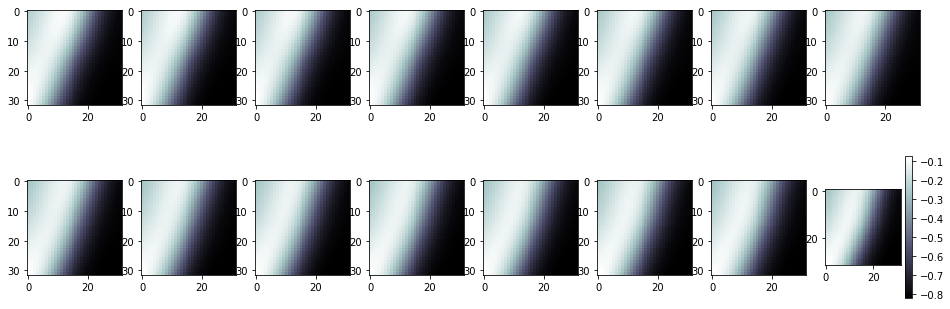

In [59]:
# np.shape(preds)
plt.figure(figsize=[16,12])
for pi in range(16):
    plt.subplot(4,8,pi+1)
#     plt.imshow(torch.squeeze(x[bind,0,:,:,pi]),cmap=plt.cm.bone)

    plt.imshow(torch.squeeze(x[bind,0,pi,:,:]),cmap=plt.cm.bone)
plt.colorbar()

Here are the ground truth slices from the original volume:

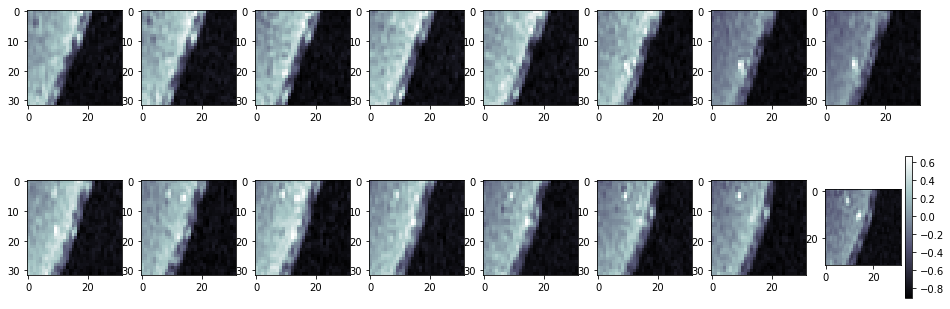

In [58]:
# np.shape(preds)
plt.figure(figsize=[16,12])
for pi in range(16):
    plt.subplot(4,8,pi+1)
#     plt.imshow(torch.squeeze(y[bind,0,:,:,pi]),cmap=plt.cm.bone)

    plt.imshow(torch.squeeze(y[bind,0,pi,:,:]),cmap=plt.cm.bone)
plt.colorbar()

Here are the predicted volume slices for the above blurry input. This seems promising.

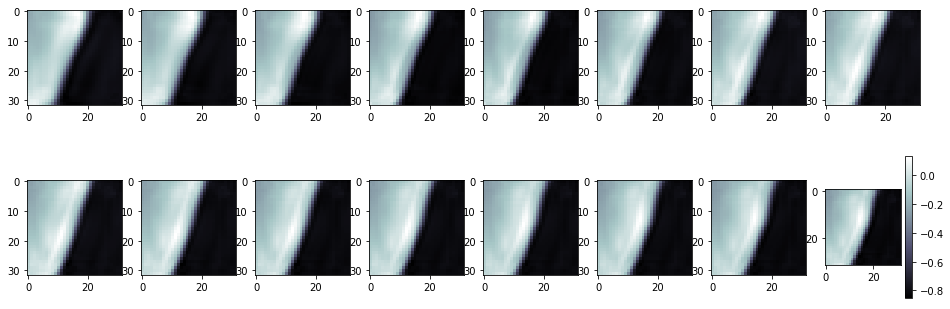

In [73]:
# np.shape(preds)
bind = 24
plt.figure(figsize=[16,12a])
for pi in range(16):
    plt.subplot(4,8,pi+1)
#     plt.imshow(torch.squeeze(preds[bind,0,:,:,pi]).data.cpu().numpy(),cmap=plt.cm.bone)
    
    plt.imshow(torch.squeeze(preds[bind,0,pi,:,:]).data.cpu().numpy(),cmap=plt.cm.bone)
plt.colorbar()

# Testing on whole MRI volumes from held-out dataset

Load a held-out original volume and blur

Center image

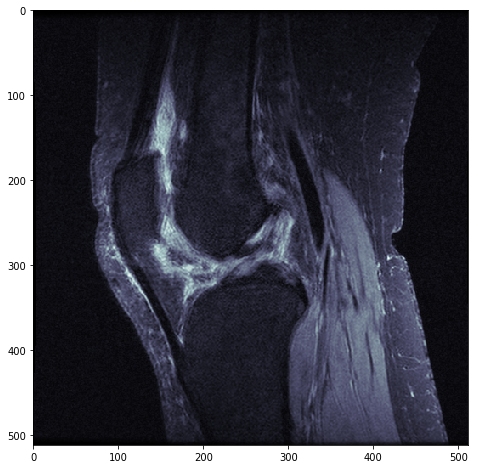

In [106]:
fig=plt.figure(figsize=[8,8])
plt.imshow(imdata[:,:,128],cmap = plt.cm.bone)

### Blur the volume - I should have used the scripts here but ran out of time

Text(0.5,1,'Super resolution output')

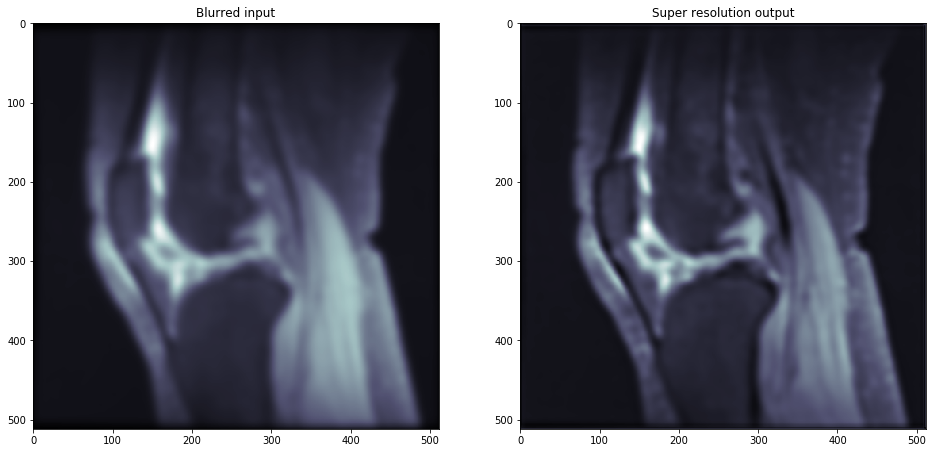

In [120]:
# def build_3d(dicom_folder):

import glob
dicom_folder = '/home/james/Documents/mri/unzipped/P20/'

image_files =glob.glob(dicom_folder+'/*.mag')

slices2d = [pydicom.dcmread(image_file) for image_file in image_files]

imdata = np.zeros([list(np.shape(slices2d[0].pixel_array))[0],list(np.shape(slices2d[0].pixel_array))[1],len(slices2d)])
sloc = []
for ii in range(len(slices2d)):
    sloc.append(slices2d[ii].get('SliceLocation'))
# plt.plot(sloc,marker='x')

ssort = np.argsort(sloc)

for ii in range(len(slices2d)):
    imdata[:,:,ii] = slices2d[ssort[ii]].pixel_array
    
    
imdata *= 1.0/np.max(imdata[:])


from scipy.ndimage import gaussian_filter
sigma_filt = 5.
imfilt = gaussian_filter(imdata, sigma=sigma_filt, mode = 'constant')

im5dsh = [1,1]
im5dsh.extend(list(np.shape(imfilt)))
im5d = np.zeros(im5dsh)
im5d[0,0,:,:,:]=imfilt
preds = learn.model(VV(im5d[0:1,0:1,:,:,105:136]))

fig=plt.figure(figsize=[16,16])
plt.subplot(1,2,1)
plt.imshow(np.squeeze(im5d[0:1,0:1,:,:,128]),cmap = plt.cm.bone)
plt.title('Blurred input')
plt.subplot(1,2,2)
plt.imshow(np.squeeze(preds[0:1,0:1,:,:,105+24-105].data.cpu().numpy()),cmap = plt.cm.bone)
plt.title('Super resolution output')

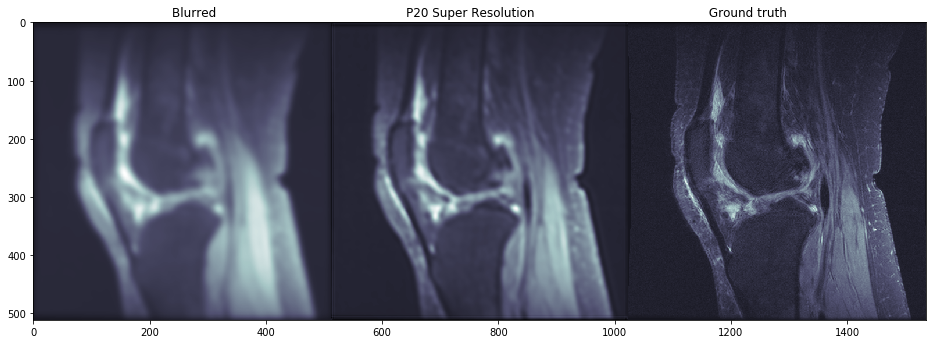

In [146]:
from IPython.display import HTML
import matplotlib.animation as animation

imbig = np.zeros([512,512*3,31])
for i in range(31):
    imsr = (np.squeeze(preds[0:1,0:1,:,:,i].data.cpu().numpy()))
    imsr *= 1.0/np.max(imsr)
    imbig[:,0:512,i] = imfilt[:,:,i+105]*1.0/np.max(imfilt[:,:,i+105])
    
    imbig[:,512:1024,i] = imsr
    
    imbig[:,1024:1024+512,i] = imdata[:,:,i+105]*1.0/np.max(imdata[:,:,i+105])
    
fig = plt.figure(figsize=[16,6])
ims = []
for i in range(31):
#     im = plt.imshow(np.squeeze(preds[0:1,0:1,:,:,i].data.cpu().numpy()), animated=True,cmap=plt.cm.bone)
    im = plt.imshow(imbig[:,:,i], animated=True,cmap=plt.cm.bone)
    plt.title('Blurred                                                 P20 Super Resolution                                             Ground truth')
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=4*50, blit=True,
                                repeat_delay=1000)

# ani.save('dynamic_images.mp4')

#plt.show()
HTML(ani.to_html5_video())

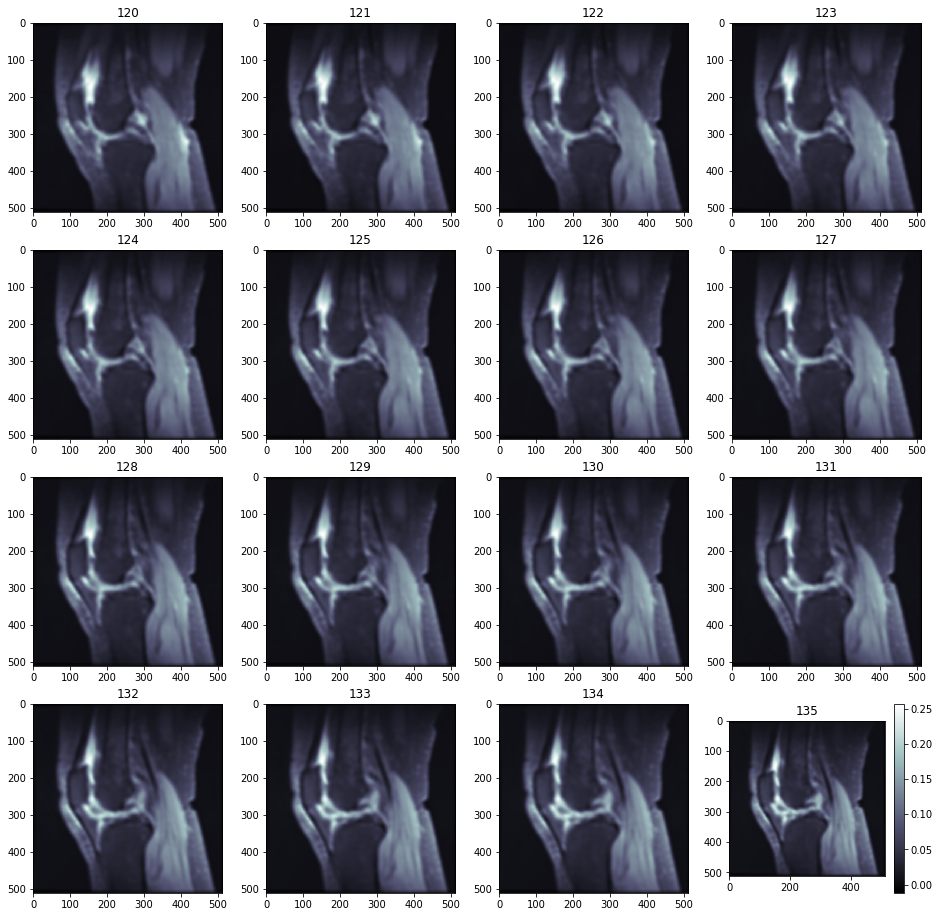

In [121]:
# np.shape(preds)
plt.figure(figsize=[16,16])
for pi in range(16):
    plt.subplot(4,4,pi+1)

    plt.imshow(np.squeeze(preds[0:1,0:1,:,:,105+24-16+pi-105].data.cpu().numpy()),cmap = plt.cm.bone)
    plt.title(str(128-8+pi))
plt.colorbar()

Text(0.5,1,'Super resolution output')

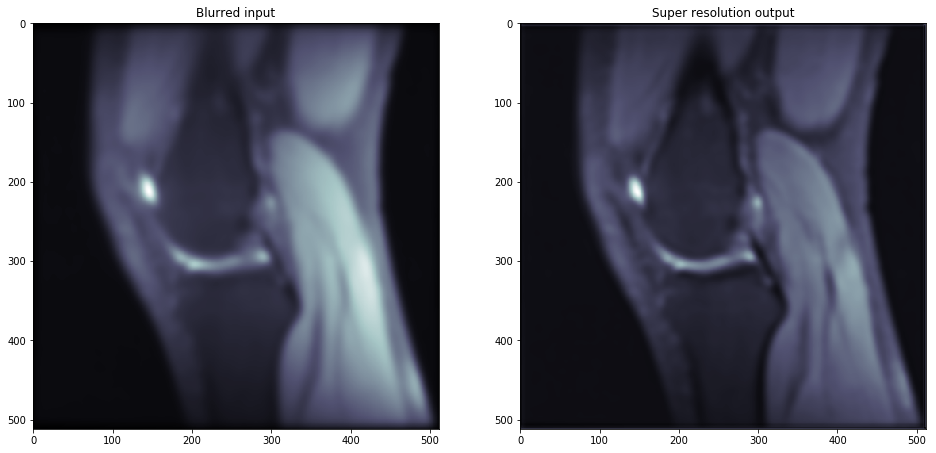

In [118]:
# def build_3d(dicom_folder):

import glob
dicom_folder = '/home/james/Documents/mri/unzipped/P6/'

image_files =glob.glob(dicom_folder+'/*.mag')

slices2d = [pydicom.dcmread(image_file) for image_file in image_files]

imdata = np.zeros([list(np.shape(slices2d[0].pixel_array))[0],list(np.shape(slices2d[0].pixel_array))[1],len(slices2d)])
sloc = []
for ii in range(len(slices2d)):
    sloc.append(slices2d[ii].get('SliceLocation'))
# plt.plot(sloc,marker='x')

ssort = np.argsort(sloc)

for ii in range(len(slices2d)):
    imdata[:,:,ii] = slices2d[ssort[ii]].pixel_array
    
    
imdata *= 1.0/np.max(imdata[:])


from scipy.ndimage import gaussian_filter
sigma_filt = 5.
imfilt = gaussian_filter(imdata, sigma=sigma_filt, mode = 'constant')

im5dsh = [1,1]
im5dsh.extend(list(np.shape(imfilt)))
im5d = np.zeros(im5dsh)
im5d[0,0,:,:,:]=imfilt
preds = learn.model(VV(im5d[0:1,0:1,:,:,105:136]))

fig=plt.figure(figsize=[16,16])
plt.subplot(1,2,1)
plt.imshow(np.squeeze(im5d[0:1,0:1,:,:,128]),cmap = plt.cm.bone)
plt.title('Blurred input')
plt.subplot(1,2,2)
plt.imshow(np.squeeze(preds[0:1,0:1,:,:,105+24-105].data.cpu().numpy()),cmap = plt.cm.bone)
plt.title('Super resolution output')

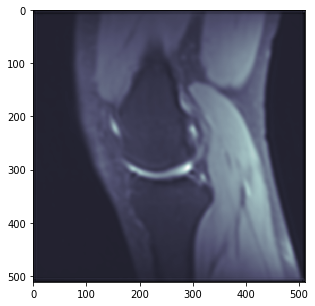

In [102]:
from IPython.display import HTML
import matplotlib.animation as animation

fig = plt.figure(figsize=[5,5])
ims = []
for i in range(31):
    im = plt.imshow(np.squeeze(preds[0:1,0:1,:,:,i].data.cpu().numpy()), animated=True,cmap=plt.cm.bone)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=4*50, blit=True,
                                repeat_delay=1000)

# ani.save('dynamic_images.mp4')

#plt.show()
HTML(ani.to_html5_video())

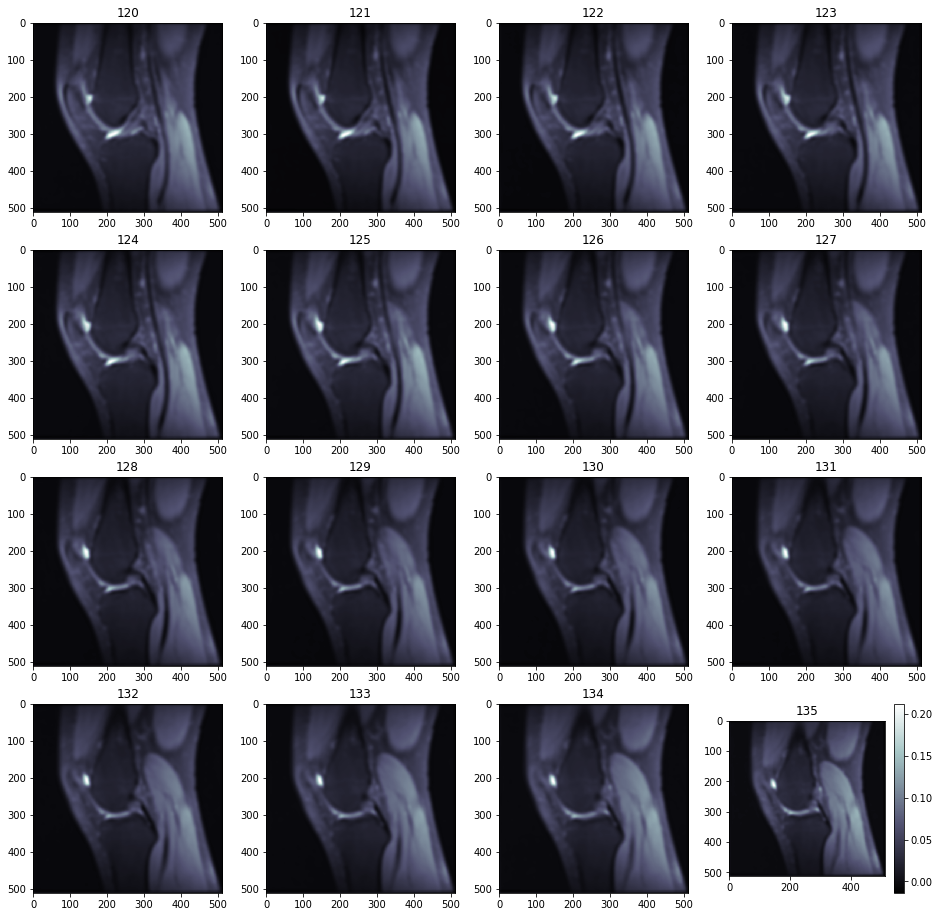

In [119]:
# np.shape(preds)
plt.figure(figsize=[16,16])
for pi in range(16):
    plt.subplot(4,4,pi+1)

    plt.imshow(np.squeeze(preds[0:1,0:1,:,:,105+24-16+pi-105].data.cpu().numpy()),cmap = plt.cm.bone)
    plt.title(str(128-8+pi))
plt.colorbar()

Text(0.5,1,'Super resolution output')

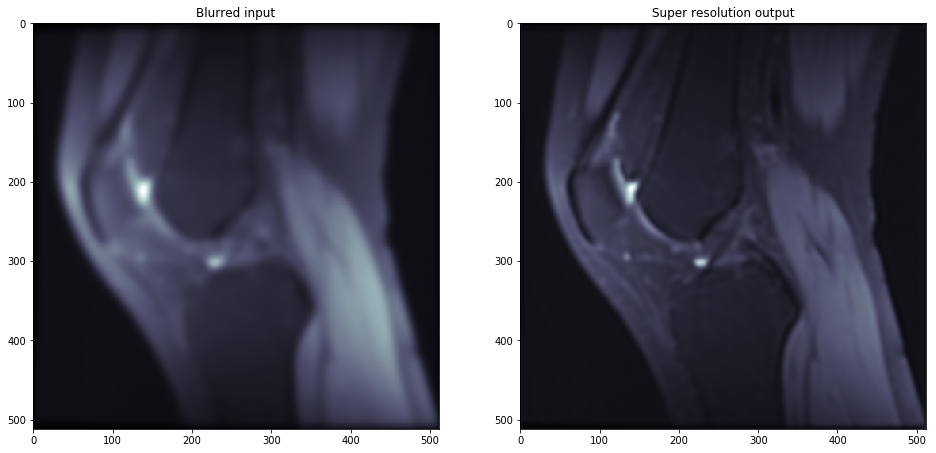

In [103]:
# def build_3d(dicom_folder):

import glob
dicom_folder = '/home/james/Documents/mri/unzipped/P4/'

image_files =glob.glob(dicom_folder+'/*.mag')

slices2d = [pydicom.dcmread(image_file) for image_file in image_files]

imdata = np.zeros([list(np.shape(slices2d[0].pixel_array))[0],list(np.shape(slices2d[0].pixel_array))[1],len(slices2d)])
sloc = []
for ii in range(len(slices2d)):
    sloc.append(slices2d[ii].get('SliceLocation'))
# plt.plot(sloc,marker='x')

ssort = np.argsort(sloc)

for ii in range(len(slices2d)):
    imdata[:,:,ii] = slices2d[ssort[ii]].pixel_array
    
    
imdata *= 1.0/np.max(imdata[:])


from scipy.ndimage import gaussian_filter
sigma_filt = 5.
imfilt = gaussian_filter(imdata, sigma=sigma_filt, mode = 'constant')

im5dsh = [1,1]
im5dsh.extend(list(np.shape(imfilt)))
im5d = np.zeros(im5dsh)
im5d[0,0,:,:,:]=imfilt
preds = learn.model(VV(im5d[0:1,0:1,:,:,105:136]))

fig=plt.figure(figsize=[16,16])
plt.subplot(1,2,1)
plt.imshow(np.squeeze(im5d[0:1,0:1,:,:,128]),cmap = plt.cm.bone)
plt.title('Blurred input')
plt.subplot(1,2,2)
plt.imshow(np.squeeze(preds[0:1,0:1,:,:,105+24-105].data.cpu().numpy()),cmap = plt.cm.bone)
plt.title('Super resolution output')

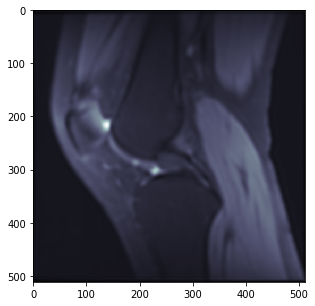

In [104]:
from IPython.display import HTML
import matplotlib.animation as animation

fig = plt.figure(figsize=[5,5])
ims = []
for i in range(31):
    im = plt.imshow(np.squeeze(preds[0:1,0:1,:,:,i].data.cpu().numpy()), animated=True,cmap=plt.cm.bone)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=4*50, blit=True,
                                repeat_delay=1000)

# ani.save('dynamic_images.mp4')

#plt.show()
HTML(ani.to_html5_video())

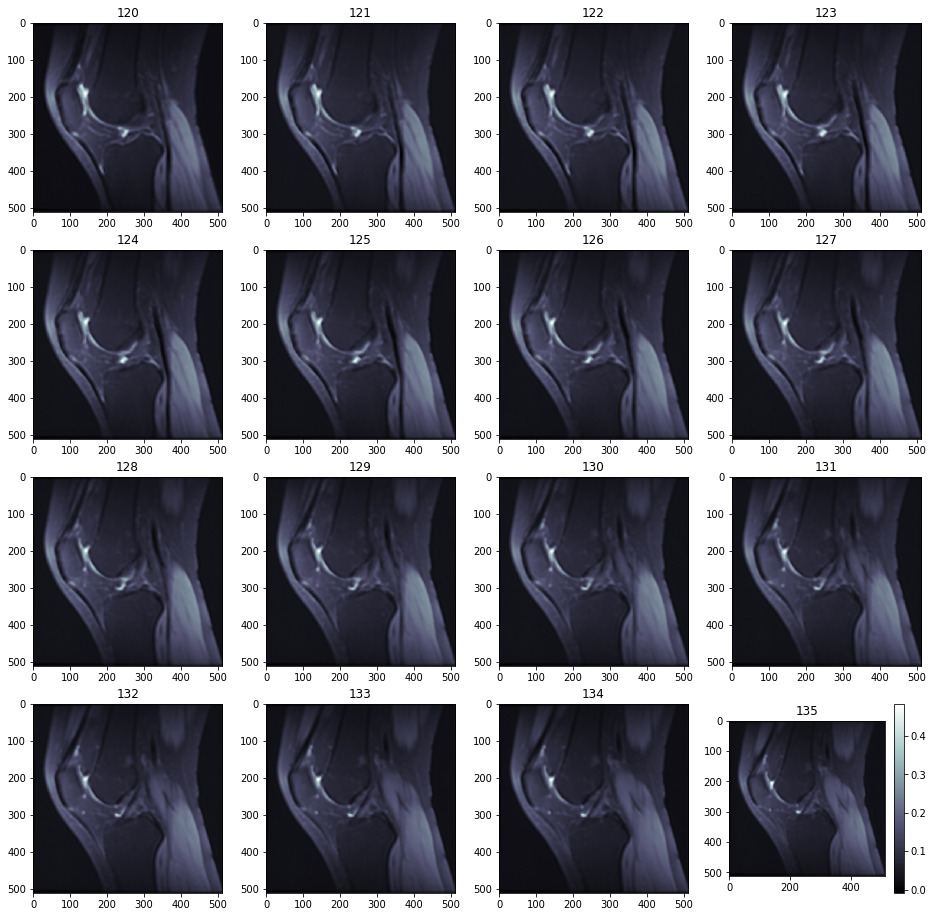

In [117]:
# np.shape(preds)
plt.figure(figsize=[16,16])
for pi in range(16):
    plt.subplot(4,4,pi+1)

    plt.imshow(np.squeeze(preds[0:1,0:1,:,:,105+24-16+pi-105].data.cpu().numpy()),cmap = plt.cm.bone)
    plt.title(str(128-8+pi))
plt.colorbar()